In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import missingno as msno
import datetime
import math as m
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

In [2]:
df = pd.read_csv('df4')

In [3]:
df.columns

Index(['Unnamed: 0', 'index', 'SETTLEMENT_DATE', 'CLIENT_RECEIVER_NAME',
       'CLIENT_RECEIVER_ACC', 'CLIENT_RECEIVER_BIC', 'FIN_CODE', 'AMOUNT',
       'CURRENCY', 'REASON1', 'REASON2', 'REG_DATE', 'REG_NO',
       'SEBRA_PAY_CODE', 'ORGANIZATION', 'PRIMARY_ORGANIZATION', 'DATE',
       'Year', 'Month', 'Day', 'IsBank', 'IsMunicipality', 'IsType',
       'Prime Ministers'],
      dtype='object')

In [4]:
df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'])
df['Date/Month'] = df['SETTLEMENT_DATE'].dt.to_period('M')

Make a case to drop data <2006-06 and data >2022-06

In [5]:
freq = []
for i in df.sort_values('SETTLEMENT_DATE', ascending = True)['Date/Month'].unique(): 
    print(i)
    freq.append(df[df['Date/Month']==i]['SETTLEMENT_DATE'].nunique())

2006-01
2006-02
2006-03
2006-04
2006-05
2006-06
2006-07
2006-08
2006-09
2006-10
2006-11
2006-12
2007-01
2007-02
2007-03
2007-04
2007-05
2007-06
2007-07
2007-08
2007-09
2007-10
2007-11
2007-12
2008-01
2008-02
2008-03
2008-04
2008-05
2008-06
2008-07
2008-08
2008-09
2008-10
2008-11
2008-12
2009-01
2009-02
2009-03
2009-04
2009-05
2009-06
2009-07
2009-08
2009-09
2009-10
2009-11
2009-12
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06
2010-07
2010-08
2010-09
2010-10
2010-11
2010-12
2011-01
2011-02
2011-03
2011-04
2011-05
2011-06
2011-07
2011-08
2011-09
2011-10
2011-11
2011-12
2012-01
2012-02
2012-03
2012-04
2012-05
2012-06
2012-07
2012-08
2012-09
2012-10
2012-11
2012-12
2013-01
2013-02
2013-03
2013-04
2013-05
2013-06
2013-07
2013-08
2013-09
2013-10
2013-11
2013-12
2014-01
2014-02
2014-03
2014-04
2014-05
2014-06
2014-07
2014-08
2014-09
2014-10
2014-11
2014-12
2015-01
2015-02
2015-03
2015-04
2015-05
2015-06
2015-07
2015-08
2015-09
2015-10
2015-11
2015-12
2016-01
2016-02
2016-03
2016-04
2016-05


192    17
193    14
194    17
195    15
196    15
197    15
198     5
199     4
200     4
201     5
202     5
203     3
dtype: int32


<AxesSubplot:>

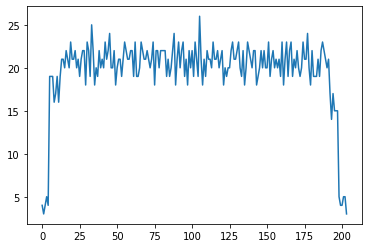

In [6]:
to_plot = pd.Series(np.array(freq))
print(to_plot[-12:])
to_plot.plot()

As predicted, the months specified above are outliers and should be dropeed.

In [7]:
df2020 = df[df['Year']>2020]

<AxesSubplot:xlabel='Date/Month'>

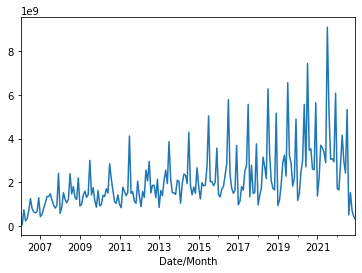

In [8]:
df.groupby('Date/Month').sum()['AMOUNT'].plot()

In [9]:
df = df[df['Date/Month']>='2006-06']
df = df[df['Date/Month']<='2022-06']
to_use = df.groupby('Date/Month').sum()

In [10]:
import plotly.express as px

fig = px.line(x=to_use.index.astype(str), y=to_use['AMOUNT'], title='Gov. spending throughout the years')
fig.show()

In [11]:
#Let's split the data set into a validaton 
#We want to have 3 years for validation and 13 for training the split is rougly 76% training and 24% validation
get_perc = 13/(len(to_use.index)/12)
print('Split here:', get_perc)
get_index = 13*12
print(get_index)

train = to_use[:get_index]
test = to_use[get_index:]

Split here: 0.8082901554404146
156


<AxesSubplot:title={'center':'Gov spending'}, xlabel='Date/Month'>

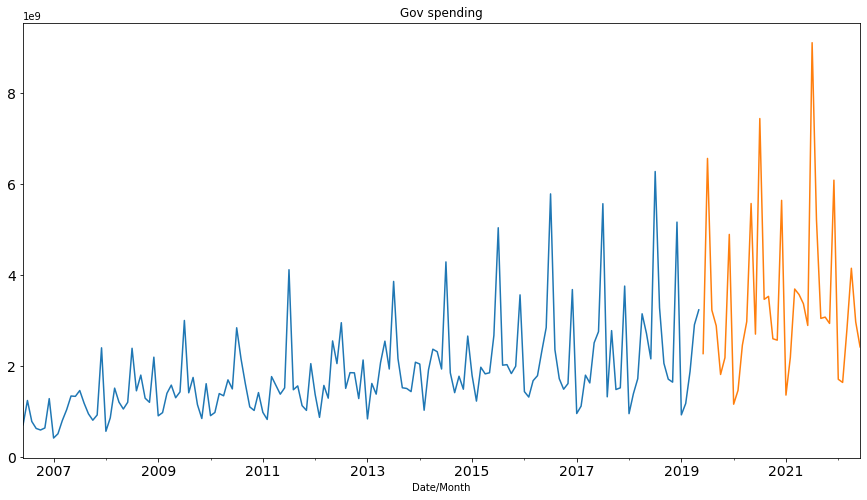

In [12]:
train.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='train') 
test.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='test')

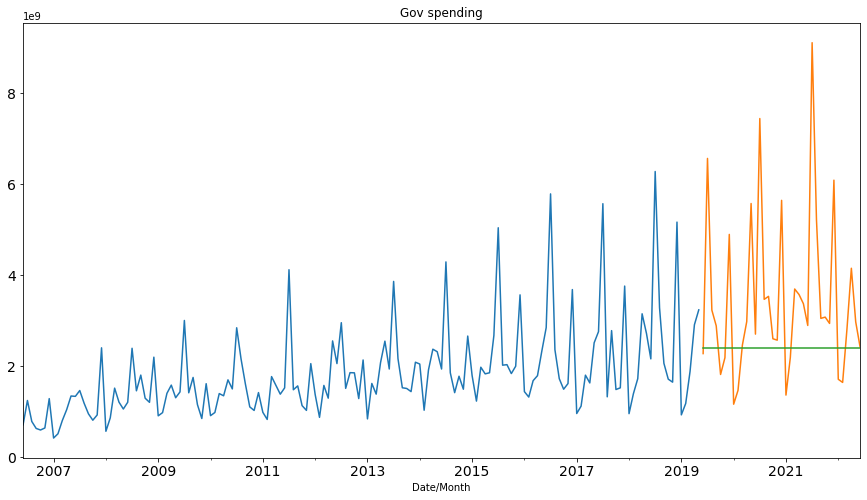

Mean absolute error:  1363978976.4292777
Mean_squared_error 4.1522379597143726e+18
Root mean squared error:  2037704090.3218436


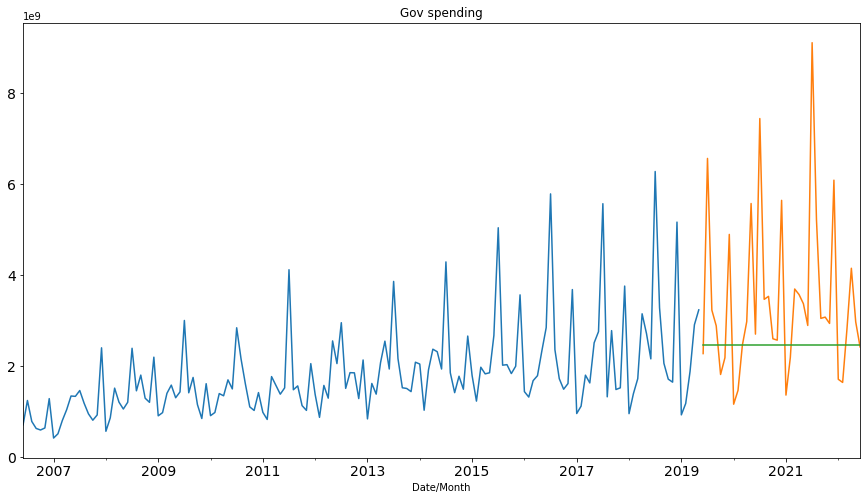

Mean absolute error:  1336755632.136169
Mean_squared_error 4.0362596987022223e+18
Root mean squared error:  2009044474.047855


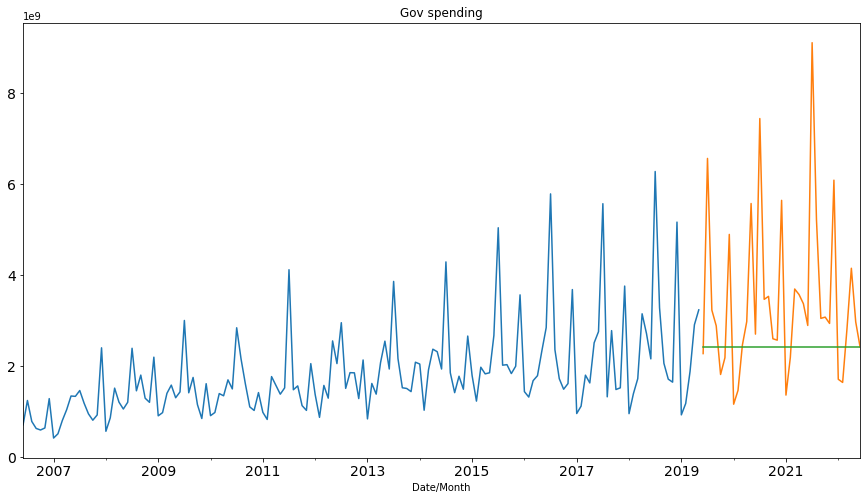

Mean absolute error:  1359033322.5847957
Mean_squared_error 4.1320913627946665e+18
Root mean squared error:  2032754624.3446765


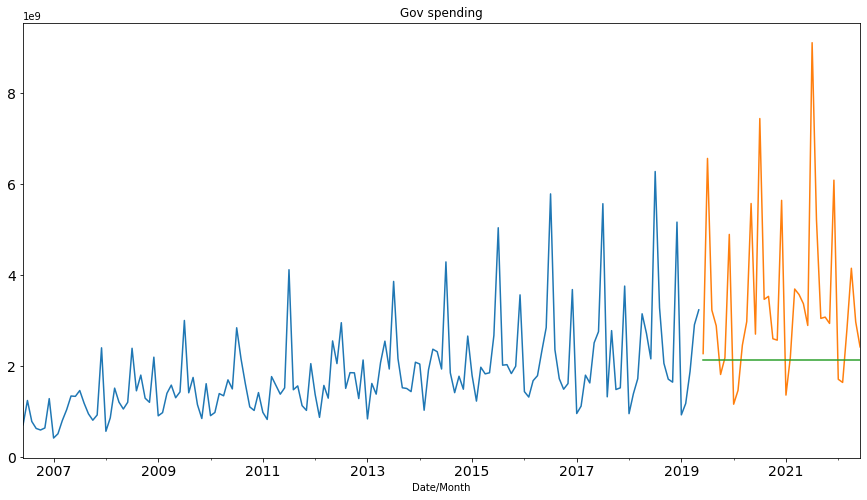

Mean absolute error:  1514172096.6437235
Mean_squared_error 4.783543521275674e+18
Root mean squared error:  2187131345.227276


In [13]:
#Let's do a moving average approach
copied = test.copy()

#See rolling avg for 10, 20, 50
for roll in [10, 20, 50, 100]:
    copied['Mov. avg'] = train['AMOUNT'].rolling(roll).mean().iloc[-1]

    train.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='train') 
    test.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='test')
    plt.plot(copied['Mov. avg'], label='Moving Average Forecast using' + str(roll) +' observations')
    plt.show()
    mae = mean_absolute_error(test['AMOUNT'], copied['Mov. avg'])
    mse = mean_squared_error(test['AMOUNT'], copied['Mov. avg'])
    rms = m.sqrt(mean_squared_error(test['AMOUNT'], copied['Mov. avg'])) 
    print('Mean absolute error: ', mae)
    print('Mean_squared_error', mse)
    print('Root mean squared error: ',rms)
    

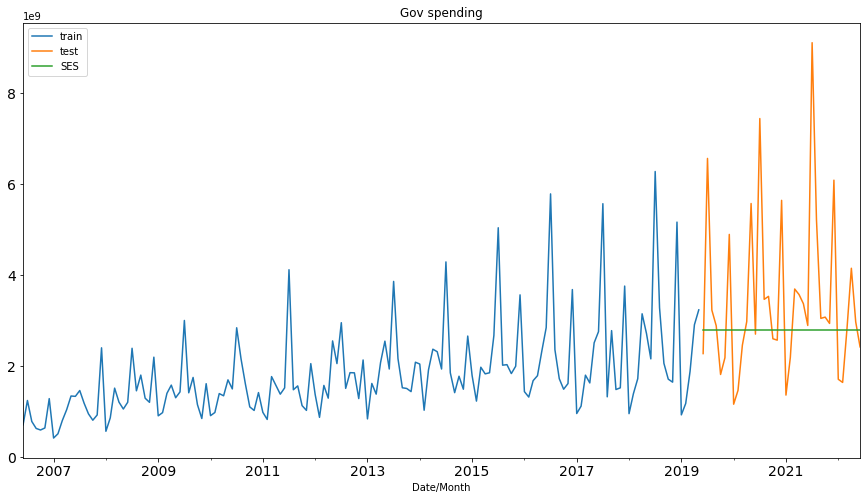

Mean absolute error:  1227332564.6040623
Mean_squared_error 3.4788327014847493e+18
Root mean squared error:  1865162915.534391


In [14]:
#The furhter back we roll, the less we respect the trend of the spending. Older years, with smaller gov spending affect the forecast.
#Let's try a Simple Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
fit2 = SimpleExpSmoothing(np.asarray(train['AMOUNT'])).fit(smoothing_level=0.5, optimized=False) 
copied['SES'] = fit2.forecast(len(test))

#Plot result
plt.figure(figsize=(16,8))  
train.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='train') 
test.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='test')
plt.plot(copied['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()
mae = mean_absolute_error(test['AMOUNT'], copied['SES'])
mse = mean_squared_error(test['AMOUNT'], copied['SES'])
rms = m.sqrt(mean_squared_error(test['AMOUNT'], copied['SES'])) 
print('Mean absolute error: ', mae)
print('Mean_squared_error', mse)
print('Root mean squared error: ',rms)

In [15]:
#Let's try a Holt regression
import statsmodels.api as sm 
train.reset_index(inplace=True)

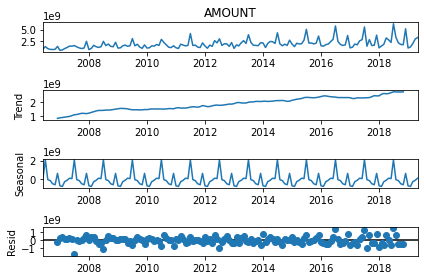

<Figure size 1152x576 with 0 Axes>

In [16]:
from pandas.tseries import frequencies
train = train.set_index('Date/Month').asfreq('M')

train.index = train.index.to_timestamp()
sm.tsa.seasonal_decompose(train['AMOUNT']).plot() 
result = sm.tsa.stattools.adfuller(train.AMOUNT) 
plt.figure(figsize=(16,8))
plt.show()

<ipython-input-17-9719e040ef41>:1: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead



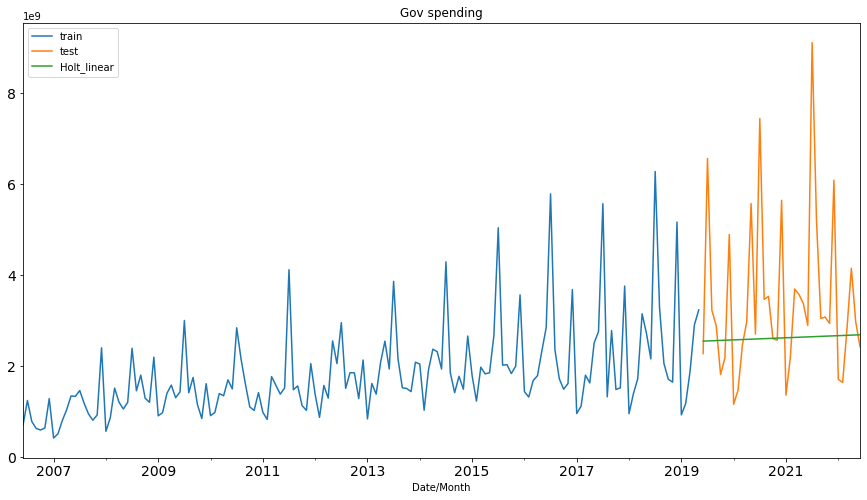

Mean absolute error:  1268506141.1504774
Mean_squared_error 3.73808670928831e+18
Root mean squared error:  1933413227.7628365


In [17]:
fit1 = Holt(np.asarray(train['AMOUNT'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
copied['Holt_linear'] = fit1.forecast(len(test)) 
plt.figure(figsize=(16,8))

train.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='train') 
test.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='test')
plt.plot(copied['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()
mae = mean_absolute_error(test['AMOUNT'], copied['Holt_linear'])
mse = mean_squared_error(test['AMOUNT'], copied['Holt_linear'])
rms = m.sqrt(mean_squared_error(test['AMOUNT'], copied['Holt_linear'])) 
print('Mean absolute error: ', mae)
print('Mean_squared_error', mse)
print('Root mean squared error: ',rms)

In [18]:
#The Holt linear model does not really predict properly 

AutoRegression for TOTAL government spending trend

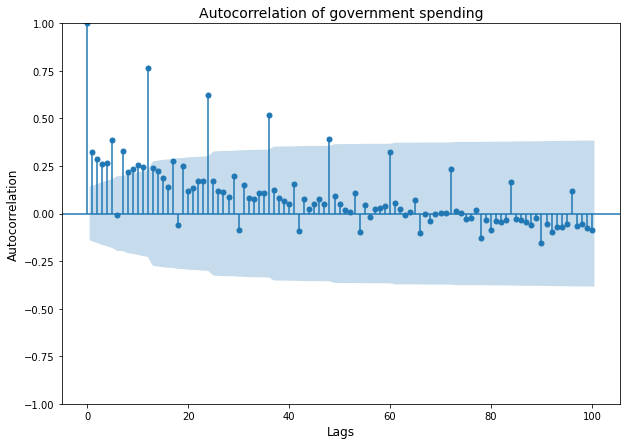

In [19]:
#Auto-regression

from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(10, 7))
# Plot ACF of JPM stock prices for past 40 lags
plot_acf(to_use.AMOUNT, lags=100)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of government spending', fontsize=14)
plt.show()


In [20]:
#Check stationarity
from statsmodels.tsa.stattools import adfuller
statio = adfuller(to_use['AMOUNT'], autolag='AIC')
print(statio)
print("P-value: ", statio[1])
#This means that data is not stationary or not with a constant trend

(0.7174833404300552, 0.9901803985511939, 15, 177, {'1%': -3.467845319799907, '5%': -2.878011745497439, '10%': -2.575551186759871}, 7648.619728054469)
P-value:  0.9901803985511939


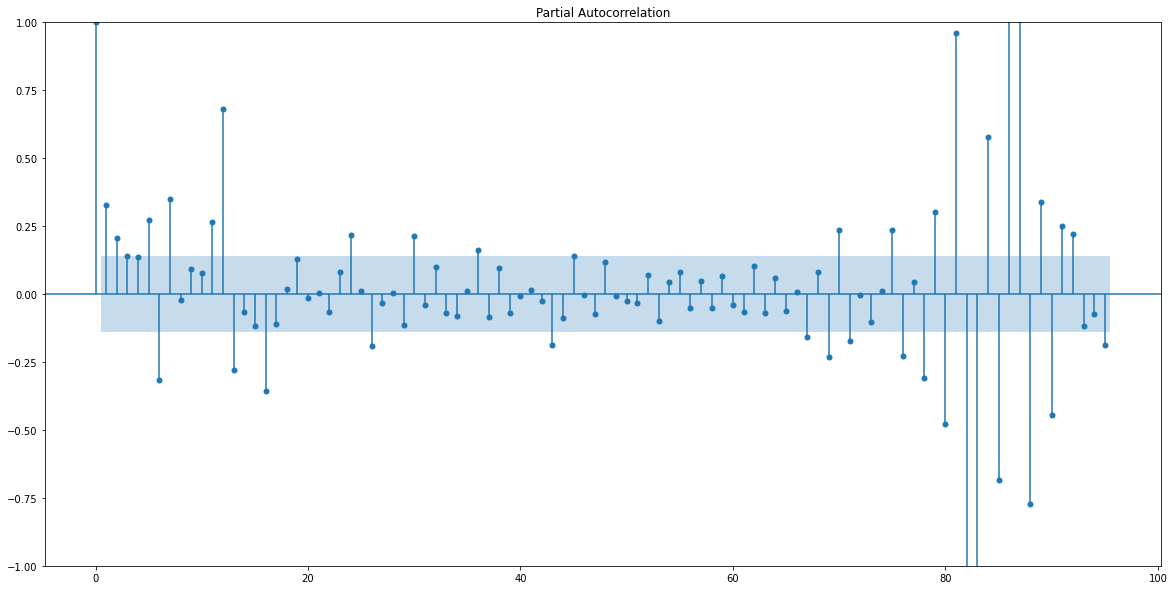

In [22]:
#Plot partial correlation to see how past data affects future data 
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure", figsize=(20, 10))
pacf = plot_pacf(to_use['AMOUNT'], lags=95)
plt.show()
#we will train the AR model of order 69. As the correlation is significant and has a fairly high r-score

In [23]:
train.reset_index(inplace=True)
test.reset_index(inplace = True)

In [24]:
#Train auto-reg model
from statsmodels.tsa.ar_model import AutoReg
autoreg_train = train['AMOUNT']
autoreg_test = test['AMOUNT']
best_lag = sm.tsa.acf(to_use['AMOUNT'])[1:].argmax()+1
print(sm.tsa.acf(to_use['AMOUNT'])[1:])
print(best_lag)
ar_model = AutoReg(autoreg_train, lags=best_lag).fit()
print(ar_model.summary())

[ 0.32540978  0.28660881  0.25841431  0.26487637  0.38632263 -0.00906823
  0.32819063  0.21734718  0.23493697  0.25673244  0.24223396  0.7623602
  0.24177646  0.22490934  0.18941902  0.13942685  0.27788075 -0.06066945
  0.24863497  0.12049854  0.13221651  0.1685763 ]
12
                            AutoReg Model Results                             
Dep. Variable:                 AMOUNT   No. Observations:                  156
Model:                    AutoReg(12)   Log Likelihood               -3079.027
Method:               Conditional MLE   S.D. of innovations      467631855.990
Date:                Thu, 01 Sep 2022   AIC                           6186.054
Time:                        19:09:51   BIC                           6227.631
Sample:                            12   HQIC                          6202.948
                                  156                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------

([<matplotlib.axis.XTick at 0x1dbaff6fd60>,
 [Text(1, 0, '2019-06'),
  Text(2, 0, '2019-07'),
  Text(3, 0, '2019-08'),
  Text(4, 0, '2019-09'),
  Text(5, 0, '2019-10'),
  Text(6, 0, '2019-11'),
  Text(7, 0, '2019-12'),
  Text(8, 0, '2020-01'),
  Text(9, 0, '2020-02'),
  Text(10, 0, '2020-03'),
  Text(11, 0, '2020-04'),
  Text(12, 0, '2020-05'),
  Text(13, 0, '2020-06'),
  Text(14, 0, '2020-07'),
  Text(15, 0, '2020-08'),
  Text(16, 0, '2020-09'),
  Text(17, 0, '2020-10'),
  Text(18, 0, '2020-11'),
  Text(19, 0, '2020-12'),
  Text(20, 0, '2021-01'),
  Text(21, 0, '2021-02'),
  Text(22, 0, '2021-03'),
  Text(23, 0, '2021-04'),
  Text(24, 0, '2021-05'),
  Text(25, 0, '2021-06'),
  Text(26, 0, '2021-07'),
  Text(27, 0, '2021-08'),
  Text(28, 0, '2021-09'),
  Text(29, 0, '2021-10'),
  Text(30, 0, '2021-11'),
  Text(31, 0, '2021-12'),
  Text(32, 0, '2022-01'),
  Text(33, 0, '2022-02'),
  Text(34, 0, '2022-03'),
  Text(35, 0, '2022-04'),
  Text(36, 0, '2022-05')])

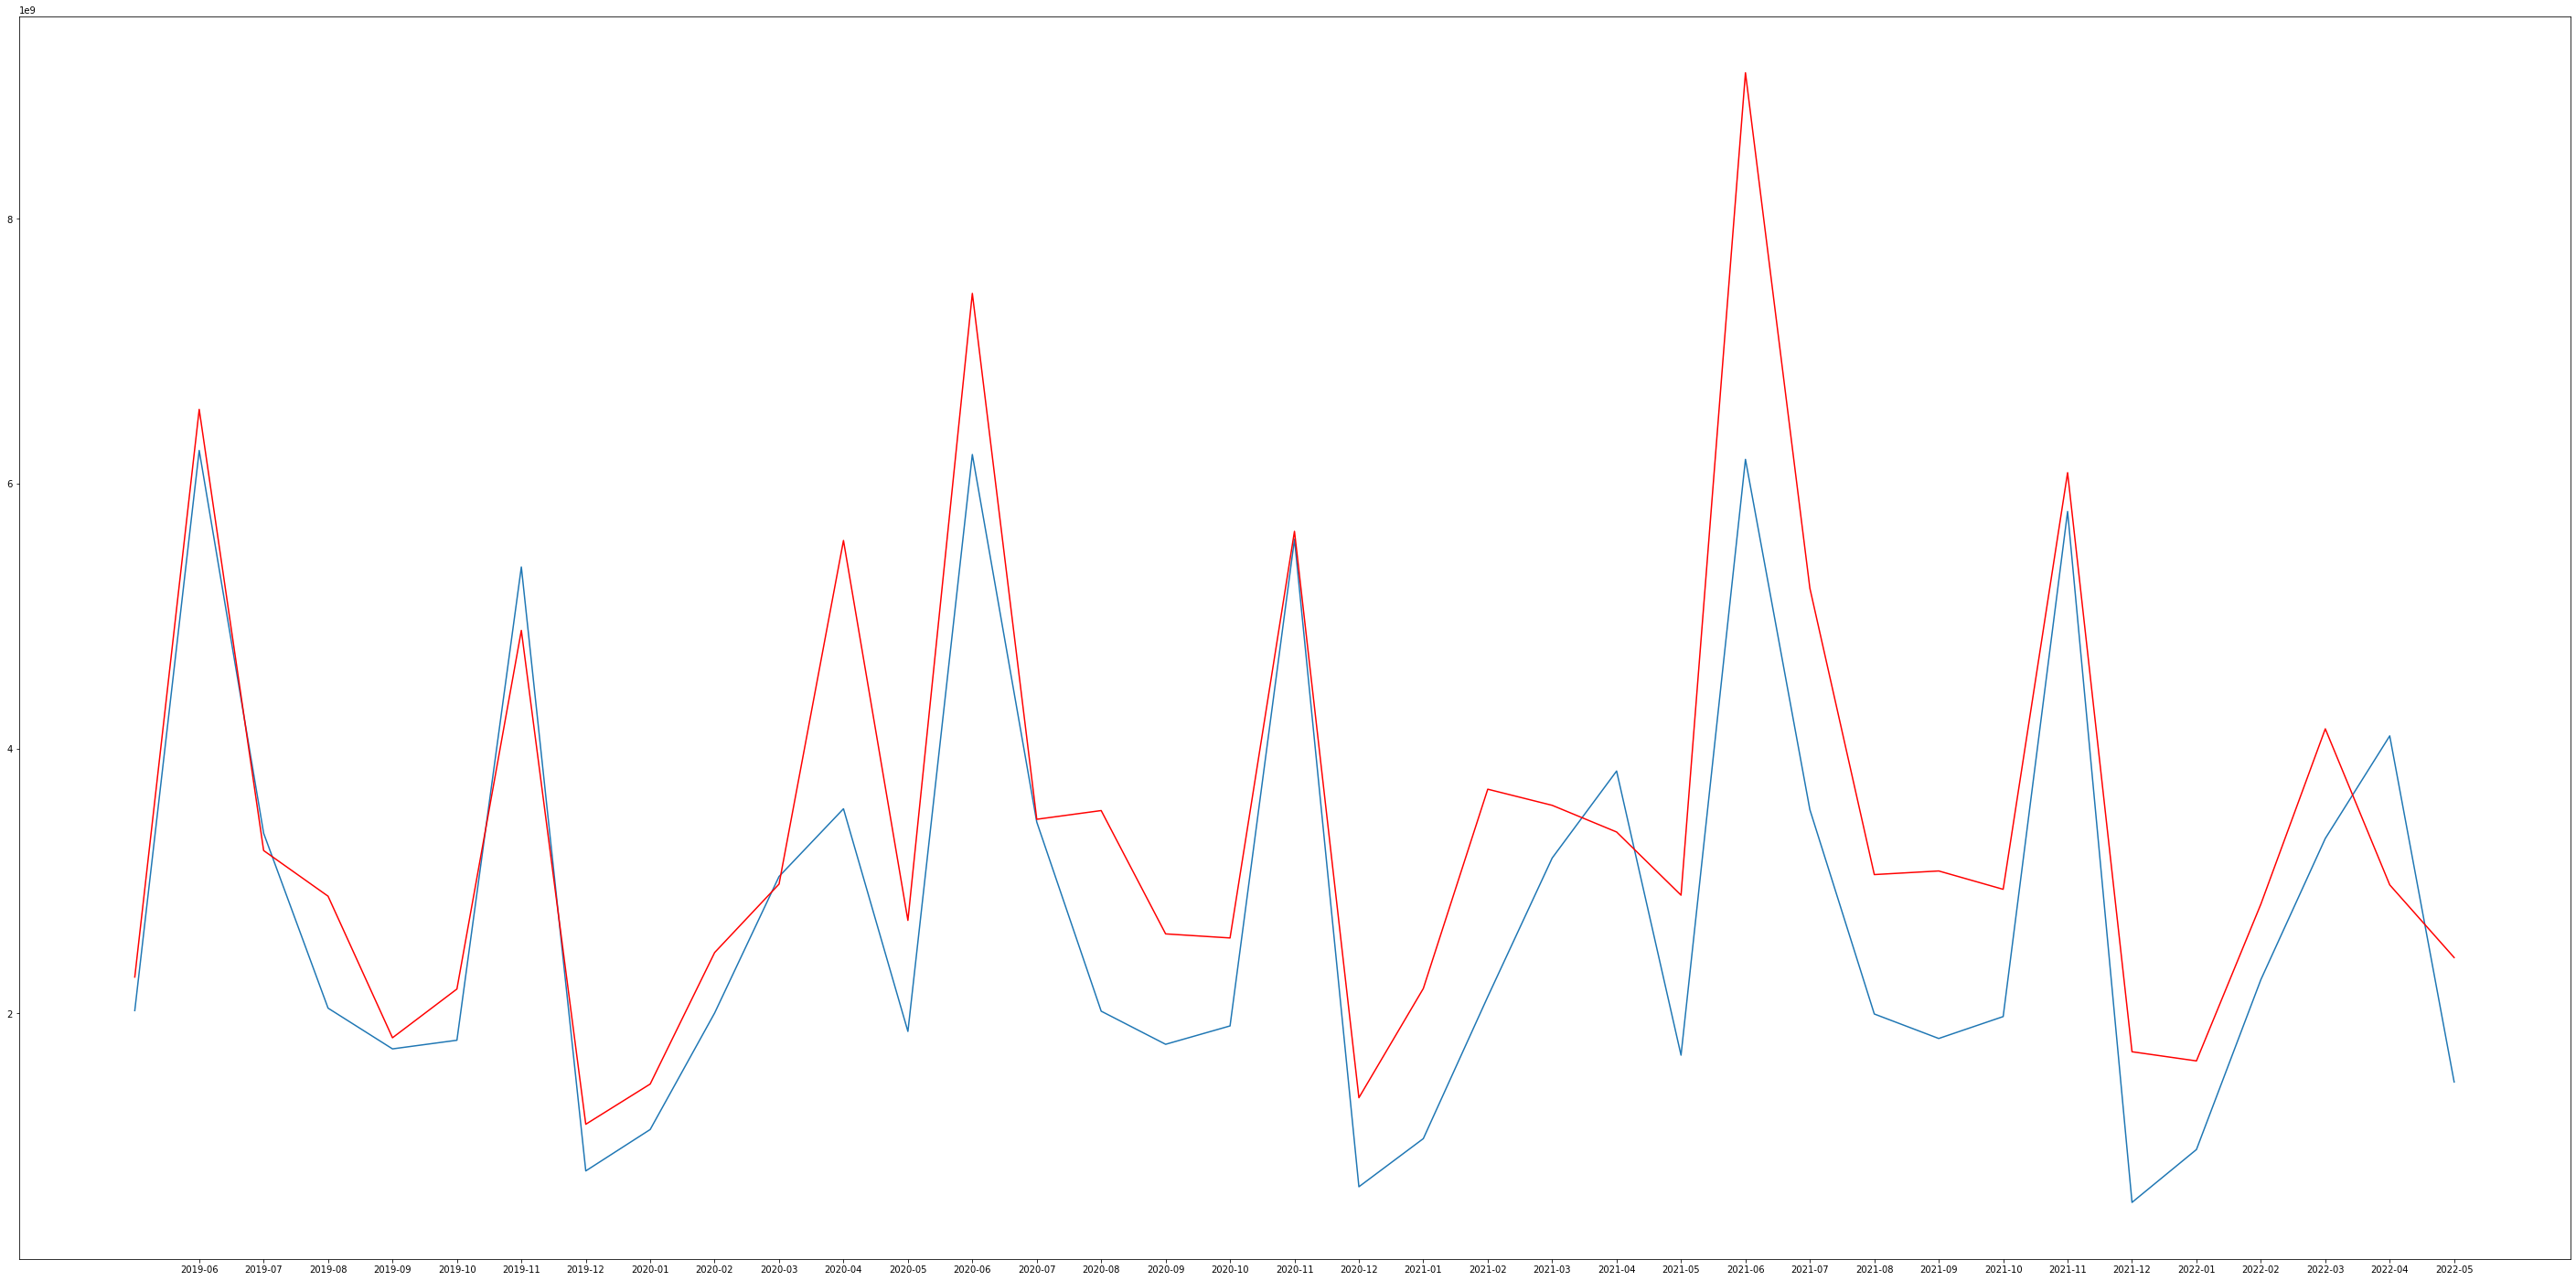

In [25]:
# Make the predictions
plt.figure(figsize=(50,25))
pred = ar_model.predict(start=len(autoreg_train), end=(len(to_use)-1), dynamic=False)
#
# Plot the prediction vs test data
#
from matplotlib import pyplot
pyplot.plot(pred.to_numpy())
pyplot.plot(autoreg_test.to_numpy(), color='red')

x_labels = test['Date/Month'][:-1]
x_ticks = range(1, len(test['Date/Month']))
plt.xticks(ticks=x_ticks, labels=x_labels)

In [26]:
list1 = ['']*len(train)
list2 = pred.to_list()
to_add = list1+list2

In [27]:
to_use['Predictions'] = to_add

In [31]:
to_use['Predictions'][-37:]

Date/Month
2019-05               
2019-06    2.02059e+09
2019-07    6.25098e+09
2019-08    3.36008e+09
2019-09    2.03909e+09
2019-10    1.73148e+09
2019-11    1.79666e+09
2019-12    5.37079e+09
2020-01    8.09866e+08
2020-02    1.12263e+09
2020-03    2.00226e+09
2020-04    3.03336e+09
2020-05    3.54473e+09
2020-06    1.86335e+09
2020-07    6.22017e+09
2020-08    3.44478e+09
2020-09    2.01624e+09
2020-10    1.76609e+09
2020-11    1.90481e+09
2020-12     5.5803e+09
2021-01    6.90114e+08
2021-02    1.05376e+09
2021-03    2.12517e+09
2021-04    3.17269e+09
2021-05    3.82986e+09
2021-06    1.68397e+09
2021-07    6.18357e+09
2021-08    3.53768e+09
2021-09    1.99488e+09
2021-10       1.81e+09
2021-11    1.97541e+09
2021-12    5.79004e+09
2022-01    5.72129e+08
2022-02    9.71318e+08
2022-03    2.25451e+09
2022-04    3.32057e+09
2022-05    4.09527e+09
2022-06    1.48142e+09
Freq: M, Name: Predictions, dtype: object

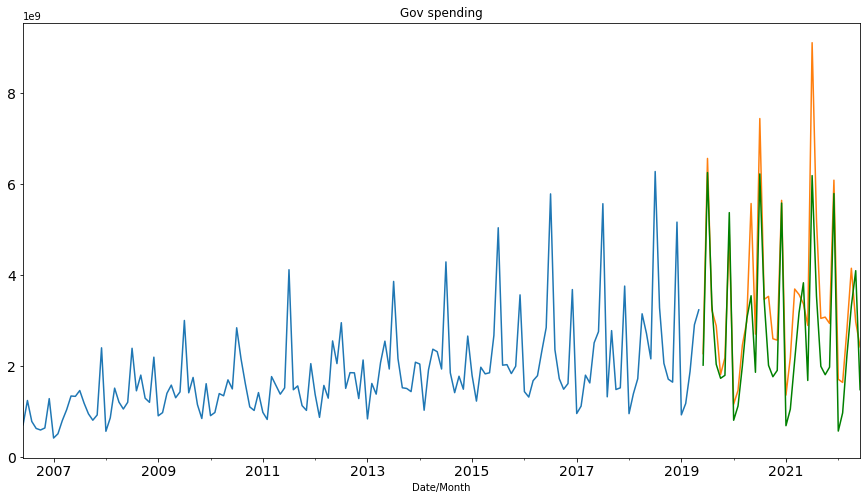

In [32]:
#Plot our regression result
train.set_index('Date/Month', inplace = True)
test.set_index('Date/Month', inplace = True)
train.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='train') 
test.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='test')
plt.plot(to_use['Predictions'][-37:].astype(float), label='AutoReg', color = 'green') 
#plt.legend(loc='best') 
plt.show()

In [33]:
#Compute metrics
mae = mean_absolute_error(to_use['AMOUNT'][-37:], to_use['Predictions'][-37:])
mse = mean_squared_error(to_use['AMOUNT'][-37:], to_use['Predictions'][-37:])
rms = m.sqrt(mean_squared_error(to_use['AMOUNT'][-37:], to_use['Predictions'][-37:])) 
print('Mean absolute error: ', mae)
print('Mean_squared_error', mse)
print('Root mean squared error: ',rms)

Mean absolute error:  803993709.378991
Mean_squared_error 1.0113774522036751e+18
Root mean squared error:  1005672636.6982822


In [34]:
#Compute Nash-Sutliffe coefficent
def nse(predictions, targets):
    return 1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2))

print(nse(to_use['Predictions'][-(len(to_use)-get_index):], to_use['AMOUNT'][-(len(to_use)-get_index):]))

0.6682034760106772


In [35]:
from sklearn.metrics import r2_score
#r2 = r2_score(to_use['AMOUNT'][-48], to_use['Predictions'][-48:])
#print(r2)

In [36]:
ar_model

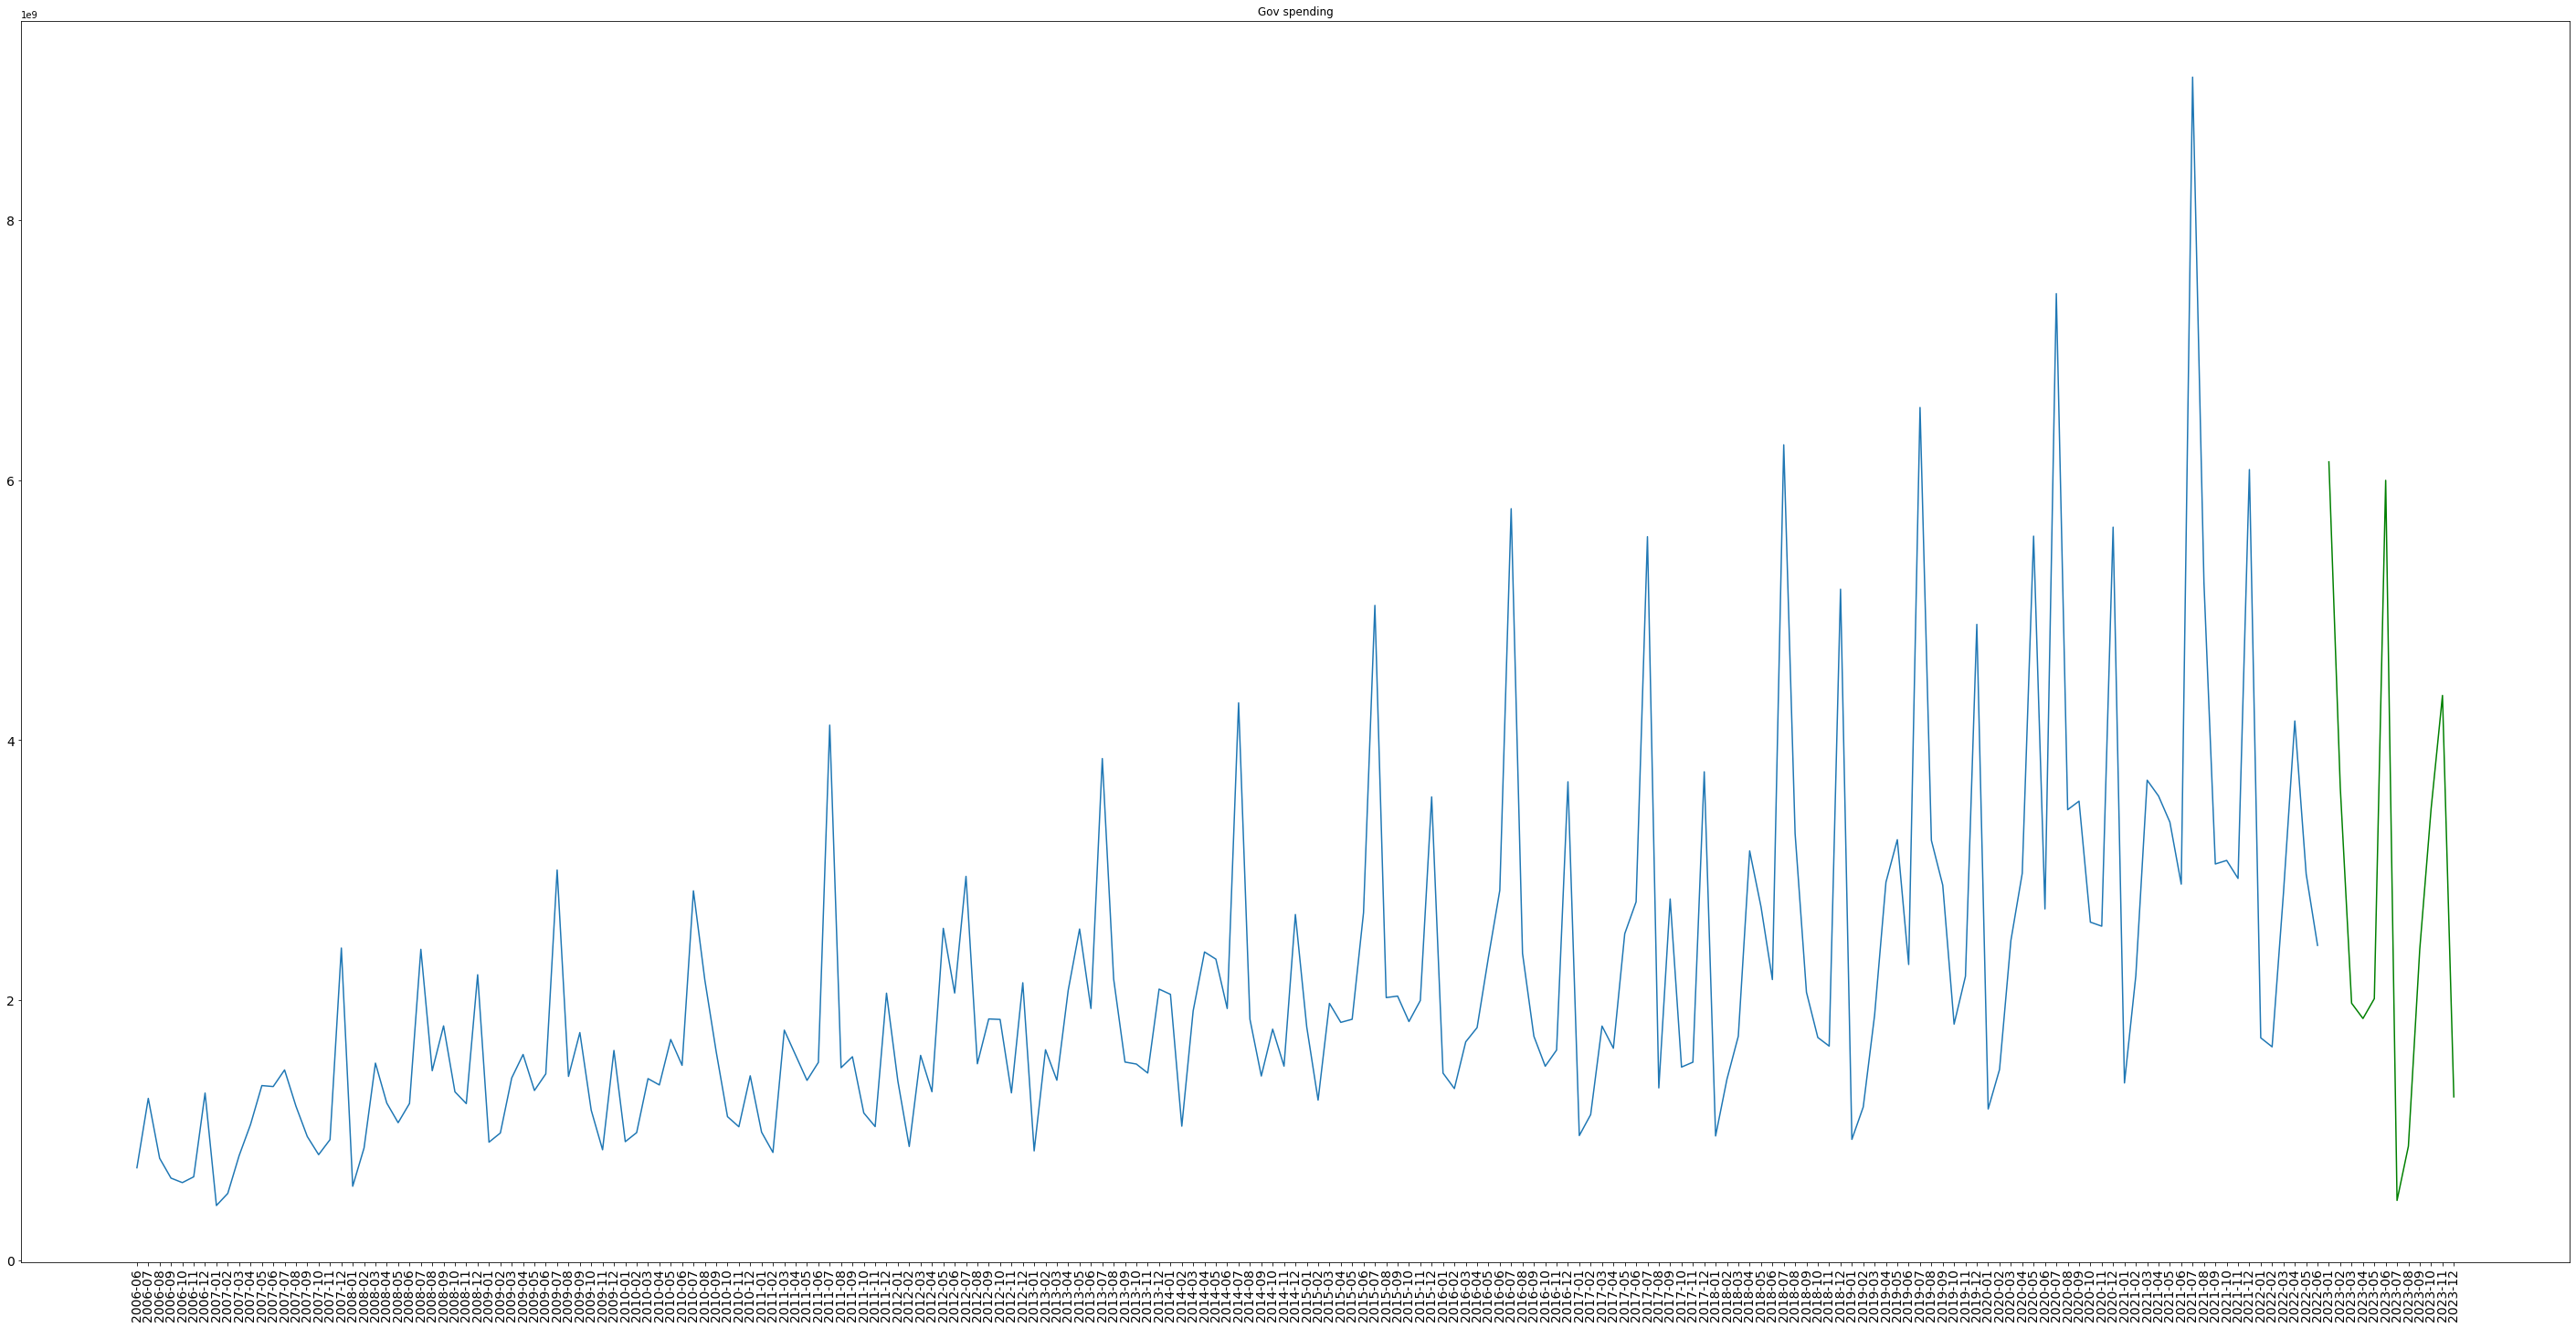

In [37]:
#adding Date/Month
new_dates = []
for i in range(1, 13):
    if i > 9:
        s = '2023-'+str(i)+'-01'
        new_dates.append(datetime.datetime.strptime(s, '%Y-%m-%d')) 
    else:
        s = '2023-0'+str(i)+'-01'
        new_dates.append(datetime.datetime.strptime(s, '%Y-%m-%d'))

#Creating a new column to 
emp = len(to_use)*['']
new_dates = emp+new_dates
to_use.reset_index(inplace = True)
new_dates=np.array(new_dates)
to_use = pd.concat([to_use, pd.Series(new_dates)], axis = 1)
to_use.rename({0: 'New_Dates'}, inplace=True, axis = 1)

#Creating a date column including the year to forecast
to_use['Date'] = to_use['Date/Month'][:12].append(to_use['New_Dates'][-12:])
to_use['Date'] = pd.to_datetime(to_use['Date'], errors='coerce')
to_use['Date'] = to_use['Date'].dt.to_period('M')
to_use['Date/Month'] = to_use['Date/Month'][:-12].append(to_use['Date'][-12:])

#Predicting and plotting for the next year using our model
pred = ar_model.predict(start=len(to_use)-12, end=len(to_use), dynamic=False)
to_use['Predictions'] = to_use['Predictions'][:-12].append(pred)
to_use.set_index('Date/Month',inplace = True)
to_use.reset_index('Date/Month', inplace = True)
to_use.AMOUNT.plot(figsize=(50,25), title= 'Gov spending', fontsize=14, label='test')
plt.plot(to_use['Predictions'][-12:], label='AutoReg', color = 'green') 
x_labels = to_use['Date/Month']
x_ticks = range(len(to_use['Date/Month']))
plt.xticks(ticks=x_ticks, labels=x_labels, rotation = 90)
plt.show()

In [ ]:
#Keep 
to_keep = df.groupby('PRIMARY_ORGANIZATION').sum().sort_values('AMOUNT', ascending =  False).index.to_numpy()

In [39]:
to_use = df.groupby('Date/Month').sum()
to_use

,Unnamed: 0,index,FIN_CODE,AMOUNT,SEBRA_PAY_CODE,Year,Month,Day
Date/Month,,,,,,,,
2006-06,102301394,102301394,7465512064014,7.099969e+08,317540,16758124,50124,161288
2006-07,240843073,240843073,9489167500023,1.243914e+09,408632,20619674,71953,171011
2006-08,238036730,238036730,6749899980298,7.829653e+08,306134,16126234,64312,147014
2006-09,275576310,275576310,6774285591157,6.303038e+08,295713,15971772,71658,147311
2006-10,324282939,324282939,6057683201514,5.956071e+08,289023,15022934,74890,147752
...,...,...,...,...,...,...,...,...
2022-02,49662594466,49662594466,18118200321700,1.640583e+09,583802,28906512,28592,253012
2022-03,68000179556,68000179556,22821617445903,2.824653e+09,940333,39313746,58329,355770
2022-04,101062978709,101062978709,29895546269070,4.148546e+09,1708661,58132500,115000,554156


In [ ]:
#to_use.reset_index(inplace = True)#.drop('Date/Month', axis = 1, inplace = True)

In [40]:
to_use = to_use['AMOUNT']

<AxesSubplot:xlabel='Date/Month'>

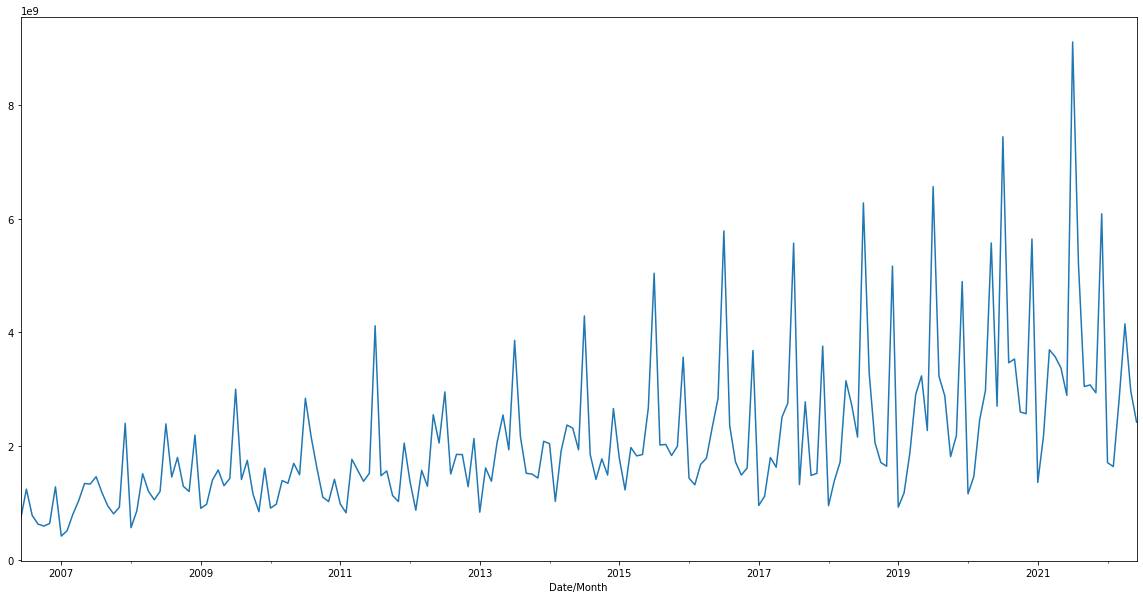

In [41]:
to_use.plot()

In [57]:
157/len(to_use)

0.8134715025906736

Date/Month
2006-06    7.099969e+08
2006-07    1.243914e+09
2006-08    7.829653e+08
2006-09    6.303038e+08
2006-10    5.956071e+08
               ...     
2022-02    1.640583e+09
2022-03    2.824653e+09
2022-04    4.148546e+09
2022-05    2.970060e+09
2022-06    2.421125e+09
Freq: M, Name: AMOUNT, Length: 193, dtype: float64
Epoch 1/100
5/5 [==============================] - 1s 68ms/step - loss: 0.0389 - mse: 0.0389 - mae: 0.1643 - val_loss: 0.1487 - val_mse: 0.1487 - val_mae: 0.3274
Epoch 2/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0297 - mse: 0.0297 - mae: 0.1350 - val_loss: 0.1187 - val_mse: 0.1187 - val_mae: 0.2773
Epoch 3/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1079 - val_loss: 0.0940 - val_mse: 0.0940 - val_mae: 0.2286
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0842 - val_loss: 0.0738 - val_mse: 0.0738 - val_mae: 0.1887
Epoch 5/100
5/5 [=========

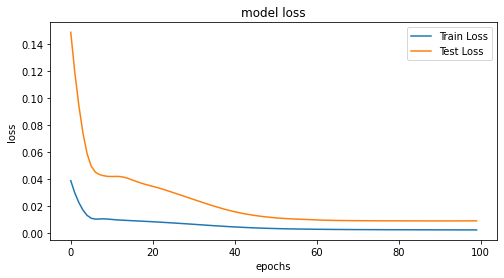

No handles with labels found to put in legend.


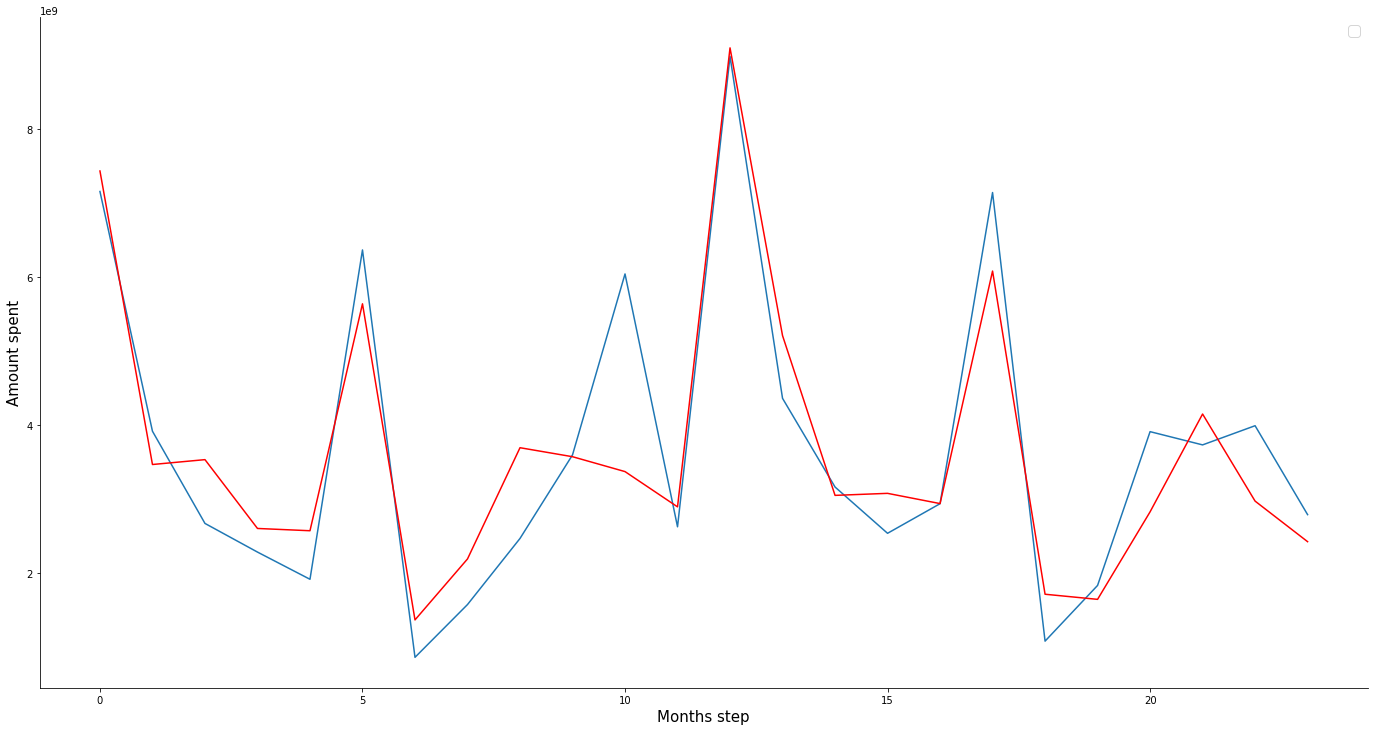

In [144]:
#LSTM model
print(to_use)
def convert2matrix(data_arr, look_back):
    X = []
    Y = []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d])
        Y.append(data_arr[d])
    return np.array(X), np.array(Y)

from sklearn.preprocessing import MinMaxScaler
df_arr= to_use.values 
df_arr = np.reshape(df_arr, (-1, 1)) #Modify input for LSTM
scaler = MinMaxScaler(feature_range=(0, 1)) #LSTM is sensitve to the scale of the features
df_arr = scaler.fit_transform(df_arr)

get_index = 157
train = df_arr[0:get_index]
test = df_arr[get_index:]

look_back = 12
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping

model=Sequential()
model.add(LSTM(100, input_shape=(1, look_back), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])

history = model.fit(trainX, trainY, 
    epochs=100, 
    validation_data=(testX, testY), 
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
    verbose=1, shuffle=False)

train_predict = model.predict(trainX)
print(testX)
test_predict = model.predict(testX)

def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    #ymax = 1
    #plt.ylim(0,ymax)
    plt.show()

def prediction_plot(testY, test_predict,look_back):
    #len_prediction=[x for x in range(len(testY)-look_back)]
    #testY = testY.reshape(45,1)
    #print(testY)
    #testY = testY.reshape(testY.shape[1], 1)
    #print(testY.shape)
    #plt.plot(len_prediction, testY[:look_back], marker='.', label="actual")
    #plt.plot(len_prediction, test_predict[:look_back], 'r', label="prediction")
    pyplot.plot(test_predict)
    pyplot.plot(testY, color='red')
    #plt.plot(testY, 'r', label="actual")
    #plt.plot(test_predict, 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Amount spent', size=15)
    #x_ticks = to_use.index[get_index]
    #plt.x_axis(x_ticks=x_ticks)
    plt.xlabel('Months step', size=15)
    plt.legend(fontsize=15)
    plt.show()

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(trainY, train_predict)),(mean_absolute_error(trainY, train_predict))))
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(testY, test_predict)),(mean_absolute_error(testY, test_predict))))
model_loss(history)
prediction_plot(testY, test_predict, look_back)


#TODO
# - Plot the result

In [145]:
#Test with Nash-Sutlif
print(nse(testY, test_predict))

0.8341418662929081


In [146]:
#Good params: 
#Projecting for 24 months
#train: 0.8, test: 0.2
#Index to split train and test data: 157
#look_back: 12 months

In [147]:
#Proportion of mistake,
print('Proportion of mistake: ',np.sqrt(mean_squared_error(testY, test_predict))/to_use[-24:].sum())


Proportion of mistake:  0.009504488978141918


In [ ]:
#TODO: 
# - Correct forecast from 12 months to 18 months
# - Create forecast with the LSTM model for 18 months
# - Plotly visuals

In [98]:
new_data = []
for i in range(7,13):
    if i < 9:
        s = '2022-'+'0'+str(i)+'-01'
        new_data.append(datetime.datetime.strptime(s, '%Y-%m-%d'))
    else: 
        s = '2022-'+str(i)+'-01'
        new_data.append(datetime.datetime.strptime(s, '%Y-%m-%d'))
else: 
    for j in range(1, 13):
        if i < 9:
            s = '2023-'+'0'+str(j)+'-01'
            new_data.append(datetime.datetime.strptime(s, '%Y-%m-%d'))
        else:
            s = '2023-'+str(j)+'-01'
            new_data.append(datetime.datetime.strptime(s, '%Y-%m-%d'))

In [99]:
new_data = pd.Series(np.array(new_data)).dt.to_period('M')

In [100]:
new_data = np.array(new_data)
print(new_data)

[Period('2022-07', 'M') Period('2022-08', 'M') Period('2022-09', 'M')
 Period('2022-10', 'M') Period('2022-11', 'M') Period('2022-12', 'M')
 Period('2023-01', 'M') Period('2023-02', 'M') Period('2023-03', 'M')
 Period('2023-04', 'M') Period('2023-05', 'M') Period('2023-06', 'M')
 Period('2023-07', 'M') Period('2023-08', 'M') Period('2023-09', 'M')
 Period('2023-10', 'M') Period('2023-11', 'M') Period('2023-12', 'M')]
(array([[Period('2022-07', 'M'), Period('2022-08', 'M'),
        Period('2022-09', 'M'), Period('2022-10', 'M'),
        Period('2022-11', 'M'), Period('2022-12', 'M'),
        Period('2023-01', 'M'), Period('2023-02', 'M'),
        Period('2023-03', 'M'), Period('2023-04', 'M'),
        Period('2023-05', 'M'), Period('2023-06', 'M')],
       [Period('2022-08', 'M'), Period('2022-09', 'M'),
        Period('2022-10', 'M'), Period('2022-11', 'M'),
        Period('2022-12', 'M'), Period('2023-01', 'M'),
        Period('2023-02', 'M'), Period('2023-03', 'M'),
        Period('2

In [118]:
new_data = [0]*18
new_data = np.array(new_data)

In [119]:
new_data = convert2matrix(new_data, look_back)
print(new_data)
new_data = np.reshape(new_data, (new_data.shape[0], 1, new_data.shape[1]))
#print(new_data)

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([0, 0, 0, 0, 0, 0]))


AttributeError: 'tuple' object has no attribute 'shape'

In [460]:
#Try new splitting method
to_use

Date/Month
2006-06    7.099969e+08
2006-07    1.243914e+09
2006-08    7.829653e+08
2006-09    6.303038e+08
2006-10    5.956071e+08
               ...     
2022-02    1.640583e+09
2022-03    2.824653e+09
2022-04    4.148546e+09
2022-05    2.970060e+09
2022-06    2.421125e+09
Freq: M, Name: AMOUNT, Length: 193, dtype: float64

1/1 [==============================] - 0s 16ms/step
-2.1429103880510465
[[2.70173420e+09]
 [7.43696980e+09]
 [3.46541248e+09]
 [3.53125167e+09]
 [2.59994535e+09]
 [2.56913882e+09]
 [5.63994177e+09]
 [1.36250797e+09]
 [2.18750196e+09]
 [3.69257792e+09]
 [3.57082839e+09]
 [3.36947192e+09]]
[[7.3604736e+09]
 [8.7754322e+09]
 [6.0791112e+09]
 [4.3500995e+09]
 [4.4537272e+09]
 [4.7546414e+09]
 [5.4035533e+09]
 [2.8796206e+09]
 [4.2480154e+09]
 [6.2035246e+09]
 [7.4934958e+09]
 [8.1481185e+09]]
[[2.70173420e+09]
 [7.43696980e+09]
 [3.46541248e+09]
 [3.53125167e+09]
 [2.59994535e+09]
 [2.56913882e+09]
 [5.63994177e+09]
 [1.36250797e+09]
 [2.18750196e+09]
 [3.69257792e+09]
 [3.57082839e+09]
 [3.36947192e+09]]
[[7.3604736e+09]
 [8.7754322e+09]
 [6.0791112e+09]
 [4.3500995e+09]
 [4.4537272e+09]
 [4.7546414e+09]
 [5.4035533e+09]
 [2.8796206e+09]
 [4.2480154e+09]
 [6.2035246e+09]
 [7.4934958e+09]
 [8.1481185e+09]]


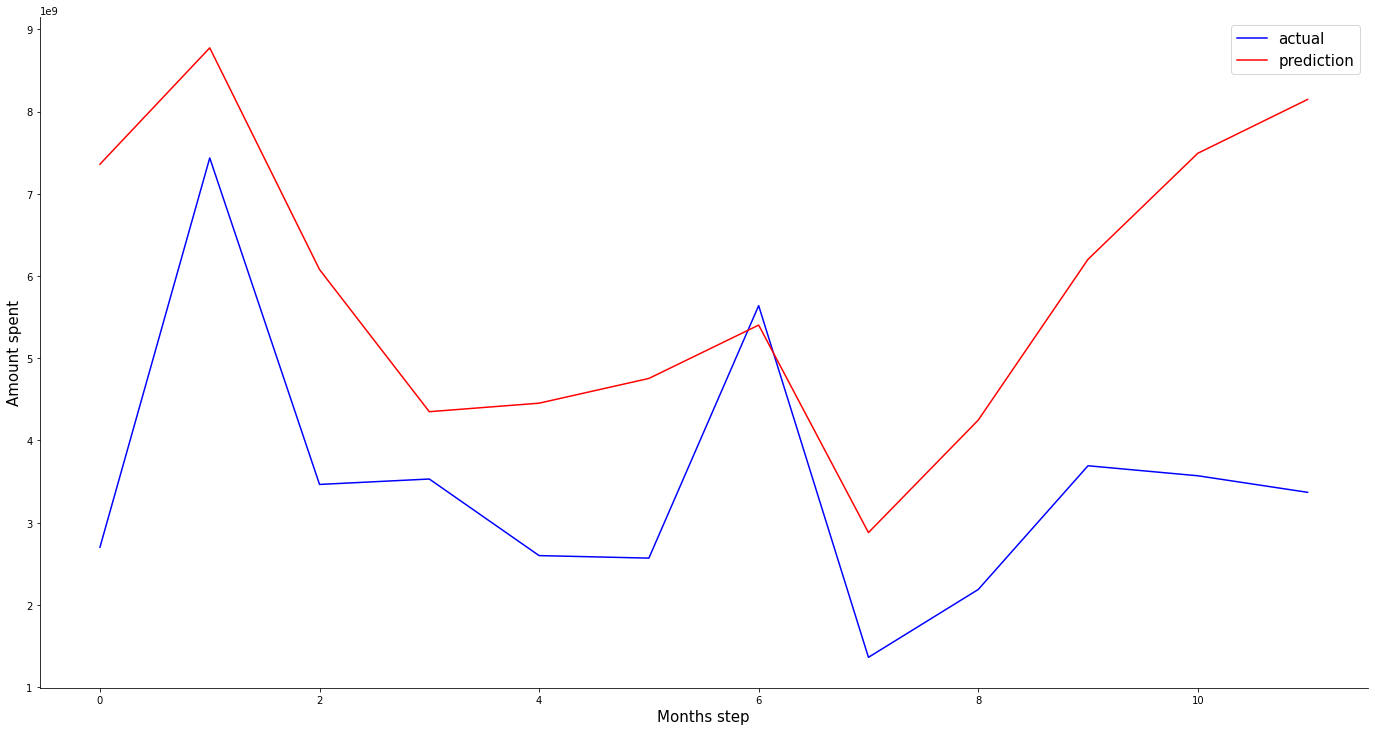

Train Root Mean Squared Error(RMSE): 2743796909.16; Train Mean Absolute Error(MAE) : 2374608997.19 
Error:  [0.06513112]
1/1 [==============================] - 0s 16ms/step


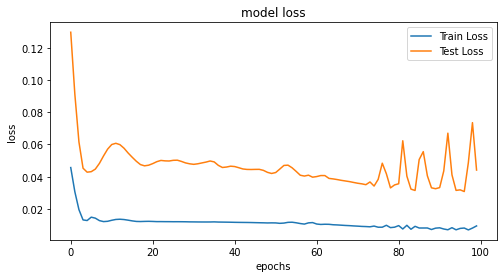

1/1 [==============================] - 0s 17ms/step


In [734]:
# Type de paiements SEBRA_PAY_CODE: Filter out for types of payment
# # scale the data
y = to_use.to_numpy().reshape(- 1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)

# generate the training sequences
n_forecast = 1
n_lookback = 12

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

#Train model
model = Sequential()
model.add(LSTM(100, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))


model.compile(loss='mse', optimizer='adam')
history = model.fit(X, Y, epochs=100, batch_size=128, validation_split=0.2, verbose=0)


#generate forecast to get model performance metrics
n_look = 12 #We will evaluate the model based on the last 12 months
y_look = []

x_pred_look = X[-2:-1, :, :]  # second last observed input sequence
#print(x_pred_look)
y_pred_look = Y[-2]
#print(y_pred_look)

real_y_look = []
predicted_y_look = []

for i in range(n_look):

    # feed the last forecast back to the model as an input
    x_pred_look = np.append(x_pred_look[:, 1:, :], y_pred_look.reshape(1, 1, 1), axis=1)
    #real_y_look.append(y_pred_look)
    # generate the next forecast
    y_pred_look = model.predict(x_pred_look)
    predicted_y_look.append(y_pred_look.flatten()[0])
    # save the forecast
#print(real_y_look)
realY = Y[-25:-13].flatten()
print(nse(predicted_y_look, realY))


def prediction_plot(testY, test_predict):
    print(testY)
    print(test_predict)
    #pyplot.plot(test_predict)
    #pyplot.plot(testY, color='red')
    plt.plot(testY, 'b', label="actual")
    plt.plot(test_predict, 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Amount spent', size=15)
    #x_ticks = to_use.index[get_index]
    #plt.x_axis(x_ticks=x_ticks)
    plt.xlabel('Months step', size=15)
    plt.legend(fontsize=15)
    plt.show()

realY = np.array(realY).reshape(-1, 1)
realY = scaler.inverse_transform(realY)
print(realY)

predicted_y_look = np.array(predicted_y_look).reshape(-1, 1)
predicted_y_look = scaler.inverse_transform(predicted_y_look)
print(predicted_y_look)

prediction_plot(realY, predicted_y_look)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(realY,predicted_y_look)),(mean_absolute_error(realY, predicted_y_look))))
print('Error: ', np.sqrt(mean_squared_error(realY,predicted_y_look))/sum(realY))

# generate the multi-step forecasts
n_future = 12
y_future = []

x_pred = X[-1:, :, :]  # last observed input sequence
y_pred = Y[-1]         # last observed target value

real_y = []
predicted_y = []

for i in range(n_future):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)
    #print(x_pred)
    #print('Actual value: ',y_pred)
    #print('\n')
    #real_y.append(y_pred)

    # generate the next forecast
    y_pred = model.predict(x_pred)
    #print('Predicted value :',y_pred)
    #predicted_y.append(y_pred)

    # save the forecast
    y_future.append(y_pred.flatten()[0])

#print(y_future)
# transform the forecasts back to the original scale
y_future = np.array(y_future).reshape(-1, 1)
y_future = scaler.inverse_transform(y_future)

model_loss(history)
y_pred = model.predict(x_pred)
#print(real_y)
#print(predicted_y)

In [735]:
print(y_future)

[[8.5213327e+09]
 [6.0722273e+09]
 [4.3780367e+09]
 [4.4651382e+09]
 [4.6966687e+09]
 [5.2357478e+09]
 [2.4506028e+09]
 [3.4583099e+09]
 [5.2070779e+09]
 [6.2851548e+09]
 [6.4885023e+09]
 [7.5647150e+09]]


<AxesSubplot:xlabel='Date/Month'>

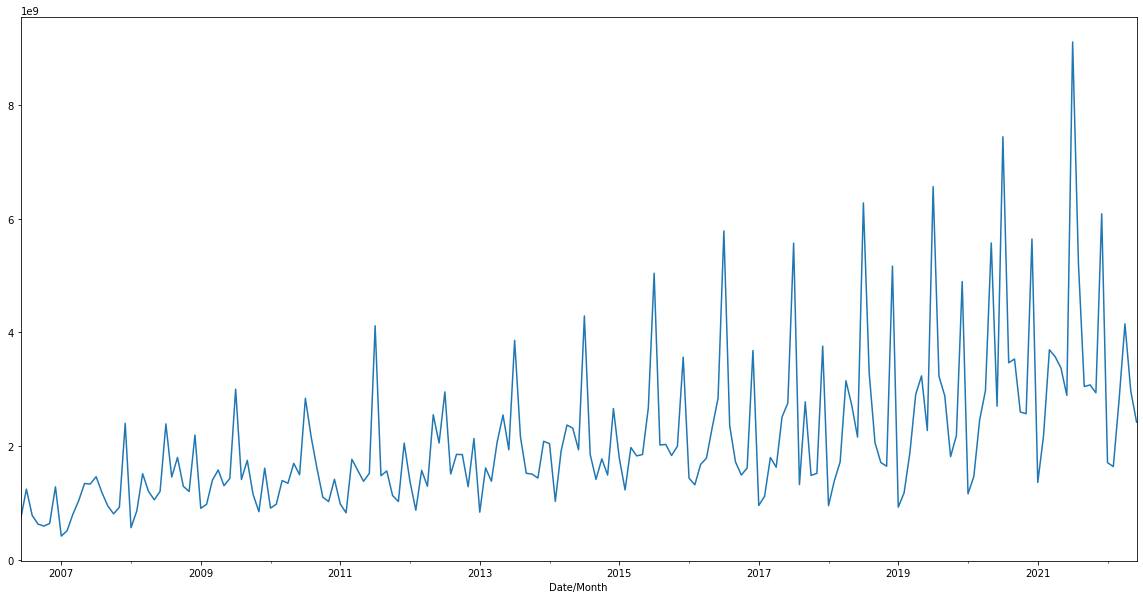

In [736]:
to_use.plot()

In [737]:
to_append = pd.Series(y_future.flatten())

In [738]:
new_data = []
for i in range(7,13):
    if i < 9:
        s = '2022-'+'0'+str(i)+'-01'
        new_data.append(datetime.datetime.strptime(s, '%Y-%m-%d'))
    else: 
        s = '2022-'+str(i)+'-01'
        new_data.append(datetime.datetime.strptime(s, '%Y-%m-%d'))
else: 
    for j in range(1, 7):
        if i < 9:
            s = '2023-'+'0'+str(j)+'-01'
            new_data.append(datetime.datetime.strptime(s, '%Y-%m-%d'))
        else:
            s = '2023-'+str(j)+'-01'
            new_data.append(datetime.datetime.strptime(s, '%Y-%m-%d'))

In [739]:
to_append = to_append.tolist()

In [740]:
df_to_add = pd.DataFrame({'Date': new_data,
     'Values': to_append 
    })

In [741]:
df_to_add['Date'] = df_to_add['Date'].dt.to_period('M')

In [742]:
df_to_add.set_index('Date', inplace = True)

In [743]:
df_to_add.rename({
    'Values' : 0
}, axis = 1, inplace = True)

In [744]:
pred_df = pd.concat([to_use, df_to_add])

<AxesSubplot:>

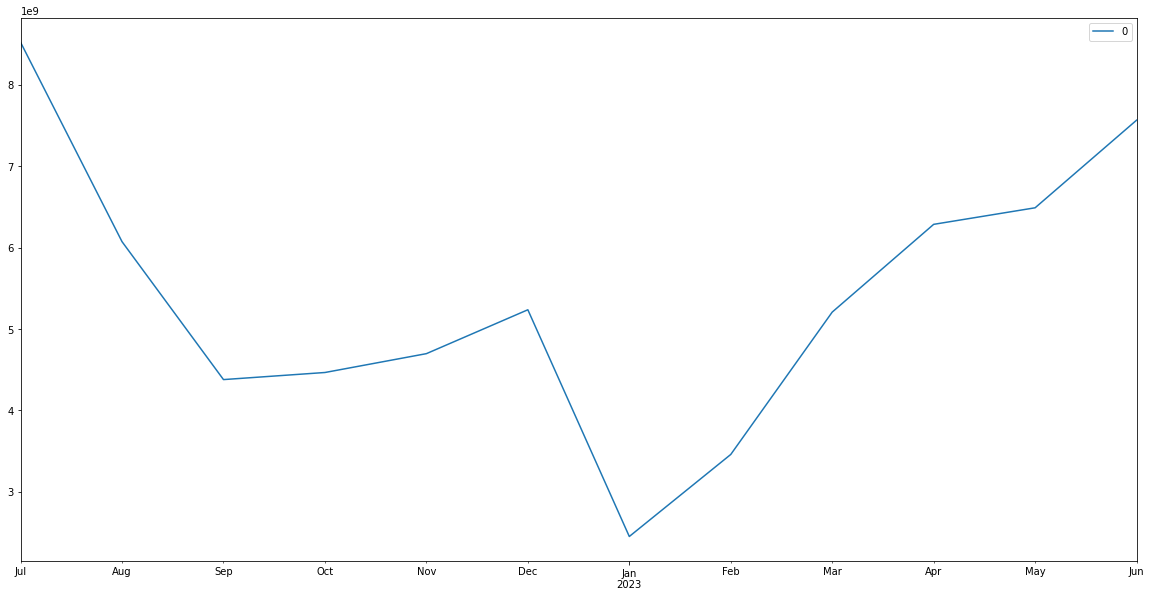

In [745]:
#pred_df[:-12].plot()
pred_df[-12:].plot()

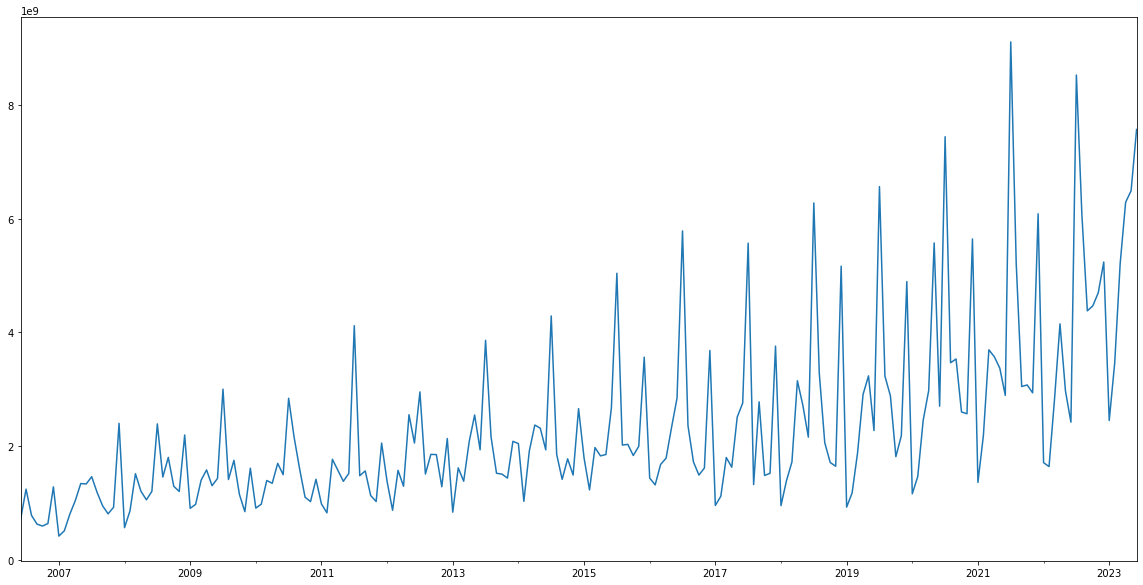

In [746]:
pred_df.rename(
    {
        0: 'Values'
    }, axis = 1, inplace = True
)
pred_df.Values.plot()
plt.show()

In [747]:
pred_df['Forecast'] = pred_df[-12:]
pred_df['Values'] = pred_df[:-12] 

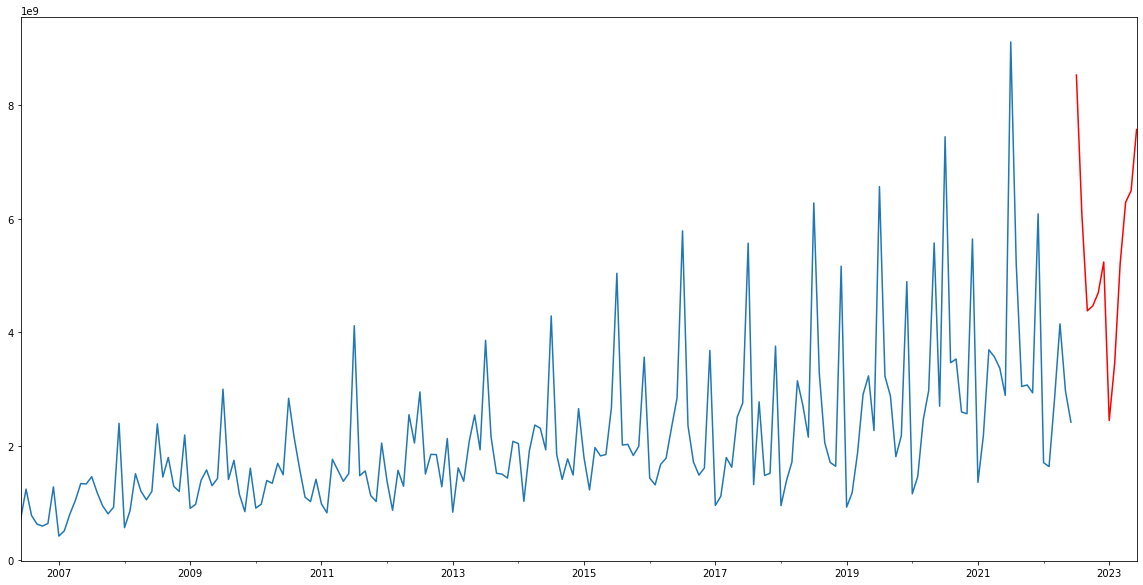

In [748]:
pred_df.Values.plot()
pred_df.Forecast.plot(color = 'red')
plt.show()

In [749]:
print(nse(Y, to_append))

-2173.4270143440503
